<a href="https://colab.research.google.com/github/YoshifumiMiyagi/VinDr-PCXR/blob/main/VinDr_PCXR_vol4(Bronchiolitis_Scoring).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [3]:
annotation = pd.read_csv('/content/drive/MyDrive/annotations_train.csv')
annotation_test = pd.read_csv('/content/drive/MyDrive/annotations_test.csv')

ohe = OneHotEncoder(sparse=False)
df_new = pd.DataFrame(ohe.fit_transform(annotation.loc[:,"class_name"].values.reshape(-1, 1)),
                      columns=ohe.get_feature_names_out(),
                      index = annotation['image_id'],
                      dtype=np.int8)
df_new.columns = ['_'.join(col.split('_')[1:]) for col in df_new.columns]
A = df_new.groupby(level=0).sum()

df_new_test = pd.DataFrame(ohe.transform(annotation_test.loc[:,"class_name"].values.reshape(-1, 1)),
                      columns=ohe.get_feature_names_out(),
                      index = annotation_test['image_id'],
                      dtype=np.int8)
df_new_test.columns = ['_'.join(col.split('_')[1:]) for col in df_new_test.columns]
A_test = df_new_test.groupby(level=0).sum()

label = pd.read_csv('/content/drive/MyDrive/image_labels_train.csv')
label_test = pd.read_csv('/content/drive/MyDrive/image_labels_test.csv')

label4 = label[(label['Bronchitis']==1)|(label['Brocho-pneumonia']==1)|(label['Bronchiolitis']==1)|(label['Pneumonia']==1)].loc[:,['image_id','Bronchitis','Brocho-pneumonia','Bronchiolitis','Pneumonia']]
label_test4 = label_test[(label_test['Bronchitis']==1)|(label_test['Brocho-pneumonia']==1)|(label_test['Bronchiolitis']==1)|(label_test['Pneumonia']==1)].loc[:,['image_id','Bronchitis','Brocho-pneumonia','Bronchiolitis','Pneumonia']]

df_label = label4.iloc[:,1:].idxmax(axis=1)
df = pd.concat([label4.iloc[:,0],df_label],axis=1)
df.columns = ['image_id','class_name']

df_label_test = label_test4.iloc[:,1:].idxmax(axis=1)
df_test = pd.concat([label_test4.iloc[:,0],df_label_test],axis=1)
df_test.columns = ['image_id','class_name']

Df = pd.merge(A,df,on='image_id',how='inner') # train_test_dataset
Df_test = pd.merge(A_test,df_test,on='image_id',how='inner') # validation_dataset
Df_test.head()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,image_id,Anterior mediastinal mass,Aortic enlargement,Atelectasis,Boot-shaped heart,Bronchectasis,Bronchial thickening,Calcification,Cardiomegaly,Chest wall mass,...,Other opacity,Paraveterbral mass,Peribronchovascular interstitial opacity,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis,Reticulonodular opacity,Stomach on the right side,class_name
0,008de51718bcafddc938be6eff91a42a,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,Bronchitis
1,015feabba4c9fb9997ef63a932587bff,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Bronchitis
2,020bb005abcb4b0d7c8f07504fc2ed2e,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,Bronchitis
3,02573bf847790859c3857a1f68d9eea4,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,Brocho-pneumonia
4,02ca701a9f51279dce17d8565db1dde5,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,Bronchitis


# Bronchiolitisを鑑別するスコアリングを検討

In [4]:
IF = ['Bronchial thickening','Consolidation','Peribronchovascular interstitial opacity','Reticulonodular opacity','Lung hyperinflation']
X_, y_ = Df.iloc[:,1:-1], Df["class_name"].replace("Bronchitis",0).replace("Brocho-pneumonia",0).replace("Bronchiolitis",1).replace("Pneumonia",0)
X_val, y_val = Df_test.iloc[:,1:-1], Df_test["class_name"].replace("Bronchitis",0).replace("Brocho-pneumonia",0).replace("Bronchiolitis",1).replace("Pneumonia",0)

X_.shape, X_val.shape, y_.shape, y_val.shape

((2157, 37), (409, 37), (2157,), (409,))

In [5]:
for i in IF:
    print(Df[i].value_counts())

Bronchial thickening
0    1604
1     363
2     163
3      20
4       5
5       2
Name: count, dtype: int64
Consolidation
0    1985
1     153
2      17
3       2
Name: count, dtype: int64
Peribronchovascular interstitial opacity
0    856
2    808
1    436
3     54
4      3
Name: count, dtype: int64
Reticulonodular opacity
0    1674
2     235
1     209
3      34
4       5
Name: count, dtype: int64
Lung hyperinflation
0    2057
2      88
1      12
Name: count, dtype: int64


In [6]:
for i in IF:
    y_true = y_
    y_score = Df[i]

    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)

    Youden_index_candidates = tpr-fpr
    index = np.where(Youden_index_candidates==max(Youden_index_candidates))[0][0]

    cutoff = thresholds[index]
    kando = tpr[index]
    tokuido = 1 - fpr[index]
    print(cutoff,"感度:",kando,"特異度：",tokuido)

inf 感度: 0.0 特異度： 1.0
inf 感度: 0.0 特異度： 1.0
2.0 感度: 0.7336343115124153 特異度： 0.6849474912485414
inf 感度: 0.0 特異度： 1.0
1.0 感度: 0.16930022573363432 特異度： 0.985414235705951


①　Peribronchovascular interstitial opacityが2か所以上（両側？？）またはLung hyperinflationが1か所以上でスコアリング

In [15]:
Df['score'] = (Df['Peribronchovascular interstitial opacity'] >= 2) | (Df['Lung hyperinflation'] >= 1)
Df_test['score'] = (Df_test['Peribronchovascular interstitial opacity'] >= 2) | (Df_test['Lung hyperinflation'] >= 1)

y_true = y_.values
y_score = Df['score'].values
auc = roc_auc_score(y_true, y_score)
print("AUC for train data:", auc)

y_true_test = y_val.values
y_score_test = Df_test['score'].values
auc_test = roc_auc_score(y_true_test, y_score_test)
print("AUC for test data:", auc_test)

fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)
kando = tpr[index]
    tokuido = 1 - fpr[index]
    print(cutoff,"感度:",kando,"特異度：",tokuido)

AUC for train data: 0.7500618989545661
AUC for test data: 0.7304466230936819


感度: 0.7294117647058823 特異度： 0.7314814814814814 AUC: 0.7304466230936819


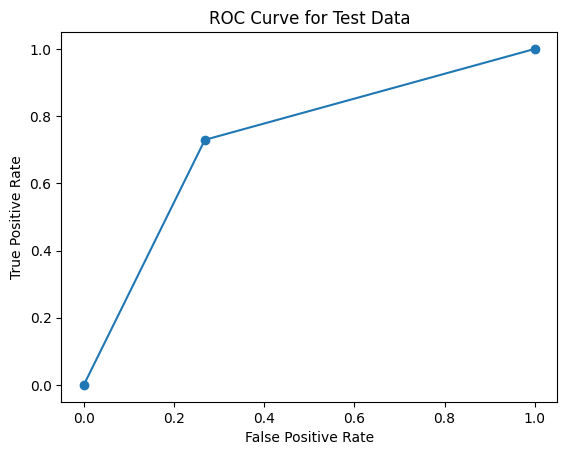

In [24]:
y_true_test = y_val.values
y_score_test = Df_test['score'].values

fpr, tpr, thresholds = metrics.roc_curve(y_true_test, y_score_test)
Youden_index_candidates = tpr-fpr
index = np.where(Youden_index_candidates==max(Youden_index_candidates))[0][0]
kando = tpr[index]
tokuido = 1 - fpr[index]
print("感度:",kando,"特異度：",tokuido,"AUC:",auc_test)

plt.figure()#figsize=(8, 6))
plt.plot(fpr, tpr, marker='o')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Data')
plt.show()


②　Peribronchovascular interstitial opacity、Lung hyperinflationの数をそれぞれ１点。計2点以上でスコアリング。

AUC for train data: 0.7495166613547706
AUC for test data: 0.7245642701525055
感度: 0.7176470588235294 特異度： 0.7314814814814814 AUC: 0.7245642701525055


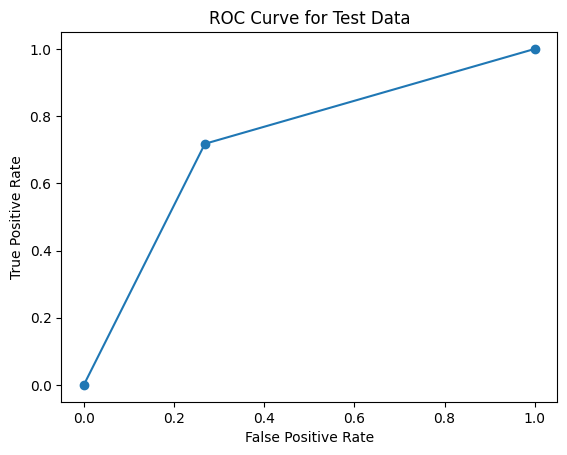

In [29]:
Df['score'] = (Df['Peribronchovascular interstitial opacity'] + Df['Lung hyperinflation'] >= 2)
Df_test['score'] = (Df_test['Peribronchovascular interstitial opacity'] + Df_test['Lung hyperinflation'] >= 2)

y_true = y_.values
y_score = Df['score'].values
auc = roc_auc_score(y_true, y_score)
print("AUC for train data:", auc)

y_true_test = y_val.values
y_score_test = Df_test['score'].values
auc_test = roc_auc_score(y_true_test, y_score_test)
print("AUC for test data:", auc_test)

y_true_test = y_val.values
y_score_test = Df_test['score'].values

fpr, tpr, thresholds = metrics.roc_curve(y_true_test, y_score_test)
Youden_index_candidates = tpr-fpr
index = np.where(Youden_index_candidates==max(Youden_index_candidates))[0][0]
kando = tpr[index]
tokuido = 1 - fpr[index]
print("感度:",kando,"特異度：",tokuido,"AUC:",auc_test)

plt.figure()#figsize=(8, 6))
plt.plot(fpr, tpr, marker='o')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Data')
plt.show()
